In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 # Argon Physical Properties
rho = 1.633             #[kg/m^3]  Density
C = 520                 #[J/kg-K]  Specific Heat Capacit
alpha = 2.2e-5          #[m^2/s]   Thermal diffusivity
mu = 3.77e-2            # Dynamic viscosity
nu = mu/rho             # [Pa-s]

#REMOVE THIS LINE!!!!!!###################################
#nu = 0.1
#REMOVE THAT LINE!!!!!!###################################

# Inlet velocity
u_inlet = 1
p_outlet = -100
p_inlet = 100

#Meshing
Lx = 0.4       #[m]
Ly = 0.4       #[m]
dx = 0.01     #[m]
dy = 0.01     #[m]
dt = 0.00001
t_max = 2     #[s]
x = np.arange(0, Lx+dx, dx)
Nx = len(x) - 1
y = np.arange(0, Ly+dy, dy)
Ny = len(y) - 1
t = np.arange(0, t_max+dt, dt)
num_timesteps = int(len(t) - 1)
# Inlet
inlet_height = 0.0
inlet_size = 0.1
outlet_height = 0.1
outlet_size = 0.1

inlet_start = int(inlet_height/dy)
print(inlet_start)
inlet_end = int((inlet_height+inlet_size)/dy)+1
print(inlet_end)

outlet_start = int(outlet_height/dy)
print(outlet_start)
outlet_end = int((outlet_height+outlet_size)/dy)+1
print(outlet_end)


tol = 1e-5

0
11
10
21


In [3]:
print('Number of points (x-direction): {0:2d} '.format(Nx+1))
print('Number of points (y-direction): {0:2d} '.format(Ny+1))
print('Mesh size (dx): {0:.8f} mm'.format(dx))
print('Mesh size (dy): {0:.8f} mm'.format(dy))
print('Number of time steps: {0:2d} '.format(num_timesteps))
print('Time step (dt): {0:.8f} s'.format(dt))


Number of points (x-direction): 41 
Number of points (y-direction): 41 
Mesh size (dx): 0.01000000 mm
Mesh size (dy): 0.01000000 mm
Number of time steps: 200000 
Time step (dt): 0.00001000 s


In [4]:
u = np.zeros((Nx+2, Ny+2))
v = np.zeros((Nx+2, Ny+2)) # Apply boundary condition on index Nx-1
p = np.zeros((Nx+2, Ny+2))

In [5]:
# Initial Condition

# Left wall
u[0,inlet_start:inlet_end] = u_inlet


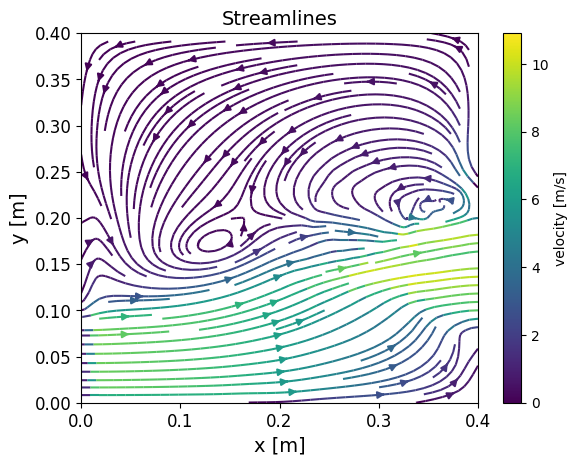

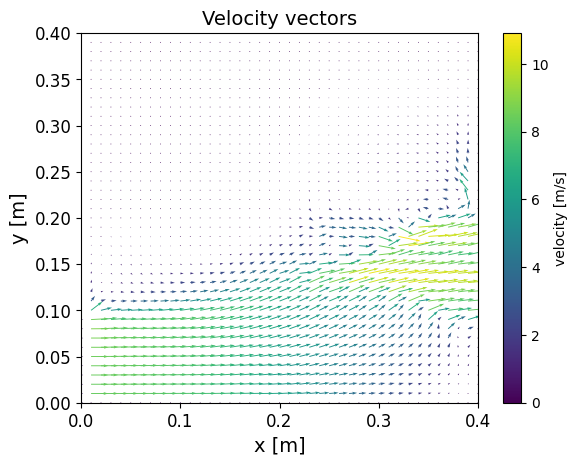

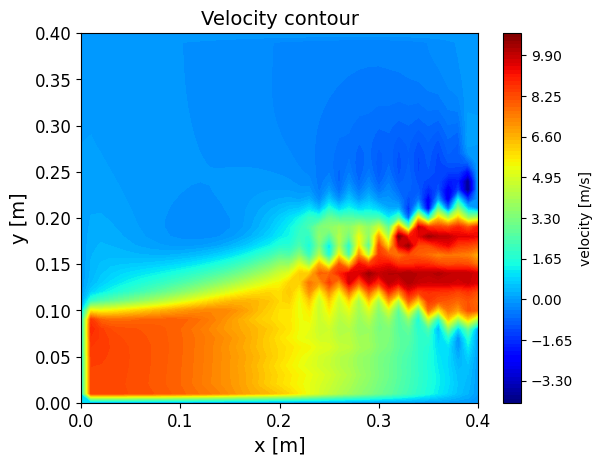

In [6]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet
        p[1,inlet_start:inlet_end] = p_inlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet
        p[1,inlet_start:inlet_end] = p_inlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store1 = u.copy()
v_store1 = v.copy()


In [ ]:

plt.contourf(xx, yy, p[1:, 1:].T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

In [ ]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store2 = u.copy()
v_store2 = v.copy()


In [ ]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store3 = u.copy()
v_store3 = v.copy()


In [ ]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store4 = u.copy()
v_store4 = v.copy()


In [ ]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store5 = u.copy()
v_store5 = v.copy()


In [ ]:
for n in range(5000):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0

    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        p[-2,:] = p[-1,:]
        p[-1,outlet_start:outlet_end] = p_outlet

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[-1,:] = p[-2,:] # Right wall
        p[0,:] = p[1,:]   # Left wall
        p[-1,outlet_start:outlet_end] = p_outlet

        error =  np.linalg.norm(p-p_ref)

        p_ref = p.copy()




    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0

    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""

plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store6 = u.copy()
v_store6 = v.copy()


In [ ]:
#u = u_store6
#v = v_store6

In [ ]:
np.savetxt("u_00_01.txt", u)
np.savetxt("v_00_01.txt", v)